# Figure 1. Read counts for for boiligical WT replicates

Code for making Figure 1 in the Nanopore DRS paper *Native long-read RNA sequencing of the Arabidopsis thaliana transcriptome*. For this figure we're focussing on two datasets; first, four biological replicates of WT col-0 tissue and second, two datasets examining the impact and addition of a 5' cap for identifying full length mRNA isoforms.

The first figure in the paper is there to highlight that a single sequencing run captures asimilar level of RNA complexity and existing gold-standard annotation. Here I load the data for all the datasets and the existing araport and AtRTD2 annotations and plot the read length histograms.

In [28]:
import pysam, numpy

def getReadLengths(bamfile):
    print("Reading data from file {}...".format(bamfile))
    thisbam = pysam.AlignmentFile(bamfile, "rb")
    readids=[]
    alignedlens=[]
    for read in thisbam.fetch():
        alignedlens.append(read.query_alignment_length)
        readids.append(read.query_name)

    alignedlens=numpy.array(alignedlens)
    readids=numpy.array(readids)
    print("\tread length information for {} reads.".format(len(readids)))
    return((readids, alignedlens))

In [29]:
# extract the read length information for each of the datasets

import os, re
data_root = "/cluster/gjb_lab/nschurch/Projects/Arabidopsis_MinION_Datasets"
bam_files = {"20180201_col0_run008_tissue2916": "20180201_col0_run008.bam",
             "20180405_col0_run010_tissue2917": "201804_col0_tissue2917.bam",
             "20180413_col0_run012_tissue2917": "201804_col0_run012_2917.bam",
             "20180416_col0_run013_tissue2918": "201804_col0_run013_2918.bam",
             "20180418_col0_run014_tissue2919": "201804_col0_run014_2919.bam",
             "20180411_col0_run011_tissue2916": "201804_col0_5adapterLIG.bam",
             "20180508_col0_run016_tissue2918": "201805_col0_run016_5padapt_2918.bam"}

read_lengths={}
for runid in bam_files.keys():
    keystr = re.sub(".+_col0_","",runid)
    bamfile = bam_files[runid]
    fullpath = os.path.join(data_root, runid, "albacore_2.2.7/aligned_data/TAIR10/", bamfile)
    read_lengths[keystr] = getReadLengths(fullpath)

Reading data from file /cluster/gjb_lab/nschurch/Projects/Arabidopsis_MinION_Datasets/20180201_col0_run008_tissue2916/albacore_2.2.7/aligned_data/TAIR10/20180201_col0_run008.bam...
	read length information for 914118 reads.
Reading data from file /cluster/gjb_lab/nschurch/Projects/Arabidopsis_MinION_Datasets/20180405_col0_run010_tissue2917/albacore_2.2.7/aligned_data/TAIR10/201804_col0_tissue2917.bam...
	read length information for 652633 reads.
Reading data from file /cluster/gjb_lab/nschurch/Projects/Arabidopsis_MinION_Datasets/20180413_col0_run012_tissue2917/albacore_2.2.7/aligned_data/TAIR10/201804_col0_run012_2917.bam...
	read length information for 866386 reads.
Reading data from file /cluster/gjb_lab/nschurch/Projects/Arabidopsis_MinION_Datasets/20180416_col0_run013_tissue2918/albacore_2.2.7/aligned_data/TAIR10/201804_col0_run013_2918.bam...
	read length information for 701167 reads.
Reading data from file /cluster/gjb_lab/nschurch/Projects/Arabidopsis_MinION_Datasets/20180418_c

In [30]:
# We're going to merge the results for runs 10 & 12 because these are the same sample sequenced 
# twice due to un unforseen laptop rooboot (ahhh windows, how I love thee!)
read_lengths["run010_tissue2917"] = (numpy.concatenate((read_lengths["run010_tissue2917"][0],
                                                        read_lengths["run012_tissue2917"][0]),
                                                        axis=None),
                                     numpy.concatenate((read_lengths["run010_tissue2917"][1],
                                                        read_lengths["run012_tissue2917"][1]),
                                                        axis=None))
del read_lengths["run012_tissue2917"]

In [31]:
# load the length information for the existing annotations

from Bio import SeqIO
annot_root = "/cluster/gjb_lab/nschurch/Projects/Arabidopsis_annotations/"

araport_fasta = os.path.join(annot_root, "Araport/v11/201606/Araport11_genes.201606.cdna.fasta")
araport_lens=[]
araport_ids=[]
for record in SeqIO.parse(araport_fasta, "fasta"):
    thislen = len(record.seq)
    araport_lens.append(thislen)
    araport_ids.append(record.id)
araport_lens = numpy.array(araport_lens)
araport_ids = numpy.array(araport_ids)

atRTD_fasta = os.path.join(annot_root, "atRTD/2016_update/AtRTD2_19April2016.fa")
atRTD_lens=[]
atRTD_ids=[]
for record in SeqIO.parse(atRTD_fasta, "fasta"):
    thislen = len(record.seq)
    atRTD_lens.append(thislen)
    atRTD_ids.append(record.id)
atRTD_lens = numpy.array(atRTD_lens)
atRTD_ids = numpy.array(atRTD_ids)

/cluster/gjb_lab/nschurch/cluster_installs/miniconda2/envs/python3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


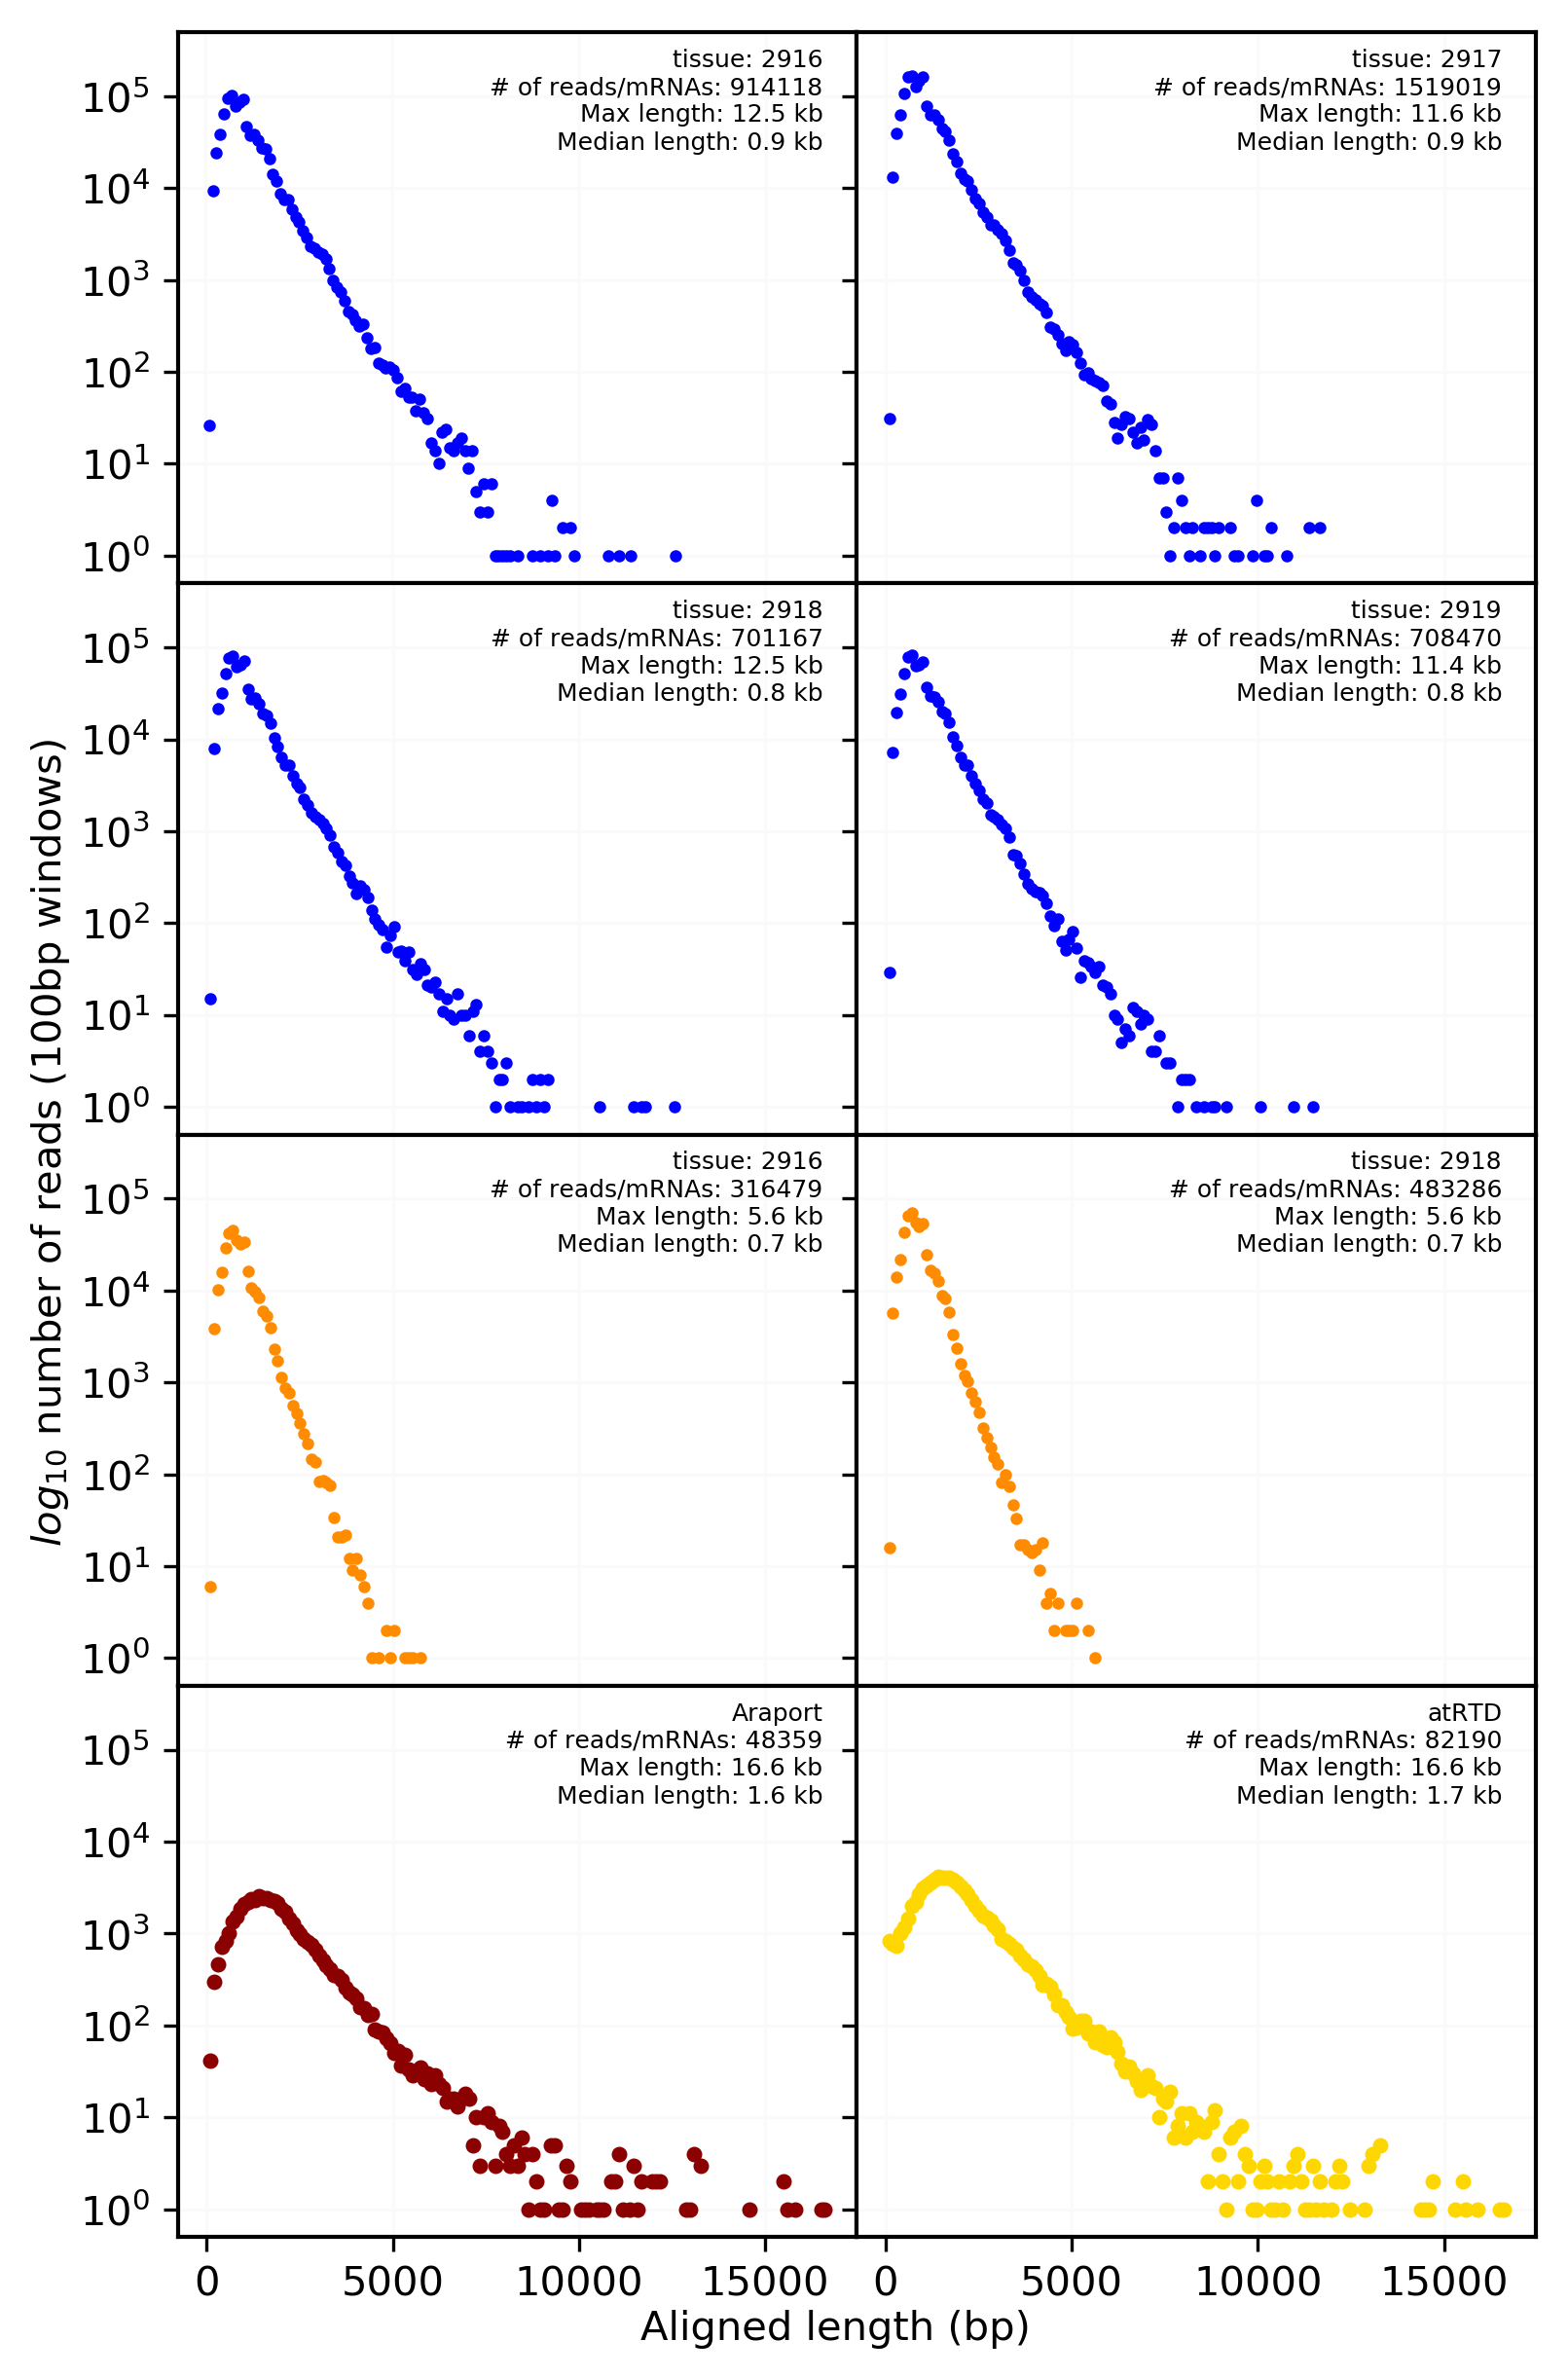

In [32]:
# Make plot
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['svg.fonttype'] = 'none'

def plotScatterHist(plot_index, data, bins, label, sharex, sharey, color=None, rows=4,
                    cols=2, s=8, fontsize=6, showxlabels=True):
    ax = plt.subplot(rows, cols, plot_index, sharex=sharex, sharey=sharey)
    rlhist = numpy.histogram(data, bins)
    if color is None:
        color='blue'
    plt.ylim(0.5,500000)
    if sharey is None:
        ax.set_yscale("log")
    else:
        plt.setp(ax.get_yticklabels(), visible=False)
    if not showxlabels:
        plt.setp(ax.get_xticklabels(), visible=False)
    ax.text(0.95, 0.95, label, ha='right', va='center',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(0.95, 0.9, "# of reads/mRNAs: {}".format(len(data)), ha='right',
            va='center', transform=ax.transAxes, fontsize=fontsize)
    ax.text(0.95, 0.85, "Max length: {:.1f} kb".format(data.max()/1E3), ha='right',
            va='center', transform=ax.transAxes, fontsize=fontsize)
    ax.text(0.95, 0.80, "Median length: {:.1f} kb".format(int(numpy.median(data))/1E3), ha='right',
            va='center', transform=ax.transAxes, fontsize=fontsize)
    plt.grid(color='0.98', linestyle='-', zorder=1)
    plt.minorticks_off()
    plt.scatter(rlhist[1][1:], rlhist[0], s=s, label=label, color=color, zorder=2)
    return(ax)

fig1 = plt.figure(figsize=(6,10), dpi=300)
subplot_index=1
bins=numpy.linspace(1,16600,16600/100)
axes=[]
for dataset in read_lengths.keys():
    if subplot_index == 1:
        sharey=None
        sharex=None
    elif subplot_index == 2:
        sharey=axes[0]
        sharex=None
    elif subplot_index == 3 or subplot_index == 5:
        sharey=None
        sharex=axes[subplot_index-2]
    else:
        sharey=axes[subplot_index-2]
        sharex=axes[subplot_index-2]
    plotlabel = "tissue: {}".format(re.sub("run.+_tissue","",dataset))
    
    color='blue'
    if subplot_index == 5 or subplot_index == 6:
        color='darkorange'
    ax = plotScatterHist(subplot_index, read_lengths[dataset][1], bins, plotlabel,
                         sharex, sharey, s=4, color=color, showxlabels=False)
    plt.subplots_adjust(hspace=.0, wspace=.0)
    axes.append(ax)
    subplot_index+=1

# add araport plot
ax = plotScatterHist(subplot_index, araport_lens, bins, "Araport",
                     axes[subplot_index-2], None, color='darkred')
axes.append(ax)
subplot_index+=1

# add atRTD
ax = plotScatterHist(subplot_index, atRTD_lens, bins, "atRTD",
                     axes[subplot_index-2], axes[subplot_index-2], color='gold')
axes.append(ax)

xlabel = fig1.text(0.5, 0.09, "Aligned length (bp)", ha='center')
ylabel = fig1.text(0.04, 0.5, r"$log_{10}$ number of reads (100bp windows)",
                   va='center', rotation='vertical')

plt.savefig("/cluster/gjb_lab/nschurch/new_cluster_workspace/ONTdrstools/Paper figures/Figure1_vert.svg",
           format='svg', transparent=True, bbox_inches='tight', frameon=False)

/cluster/gjb_lab/nschurch/cluster_installs/miniconda2/envs/python3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


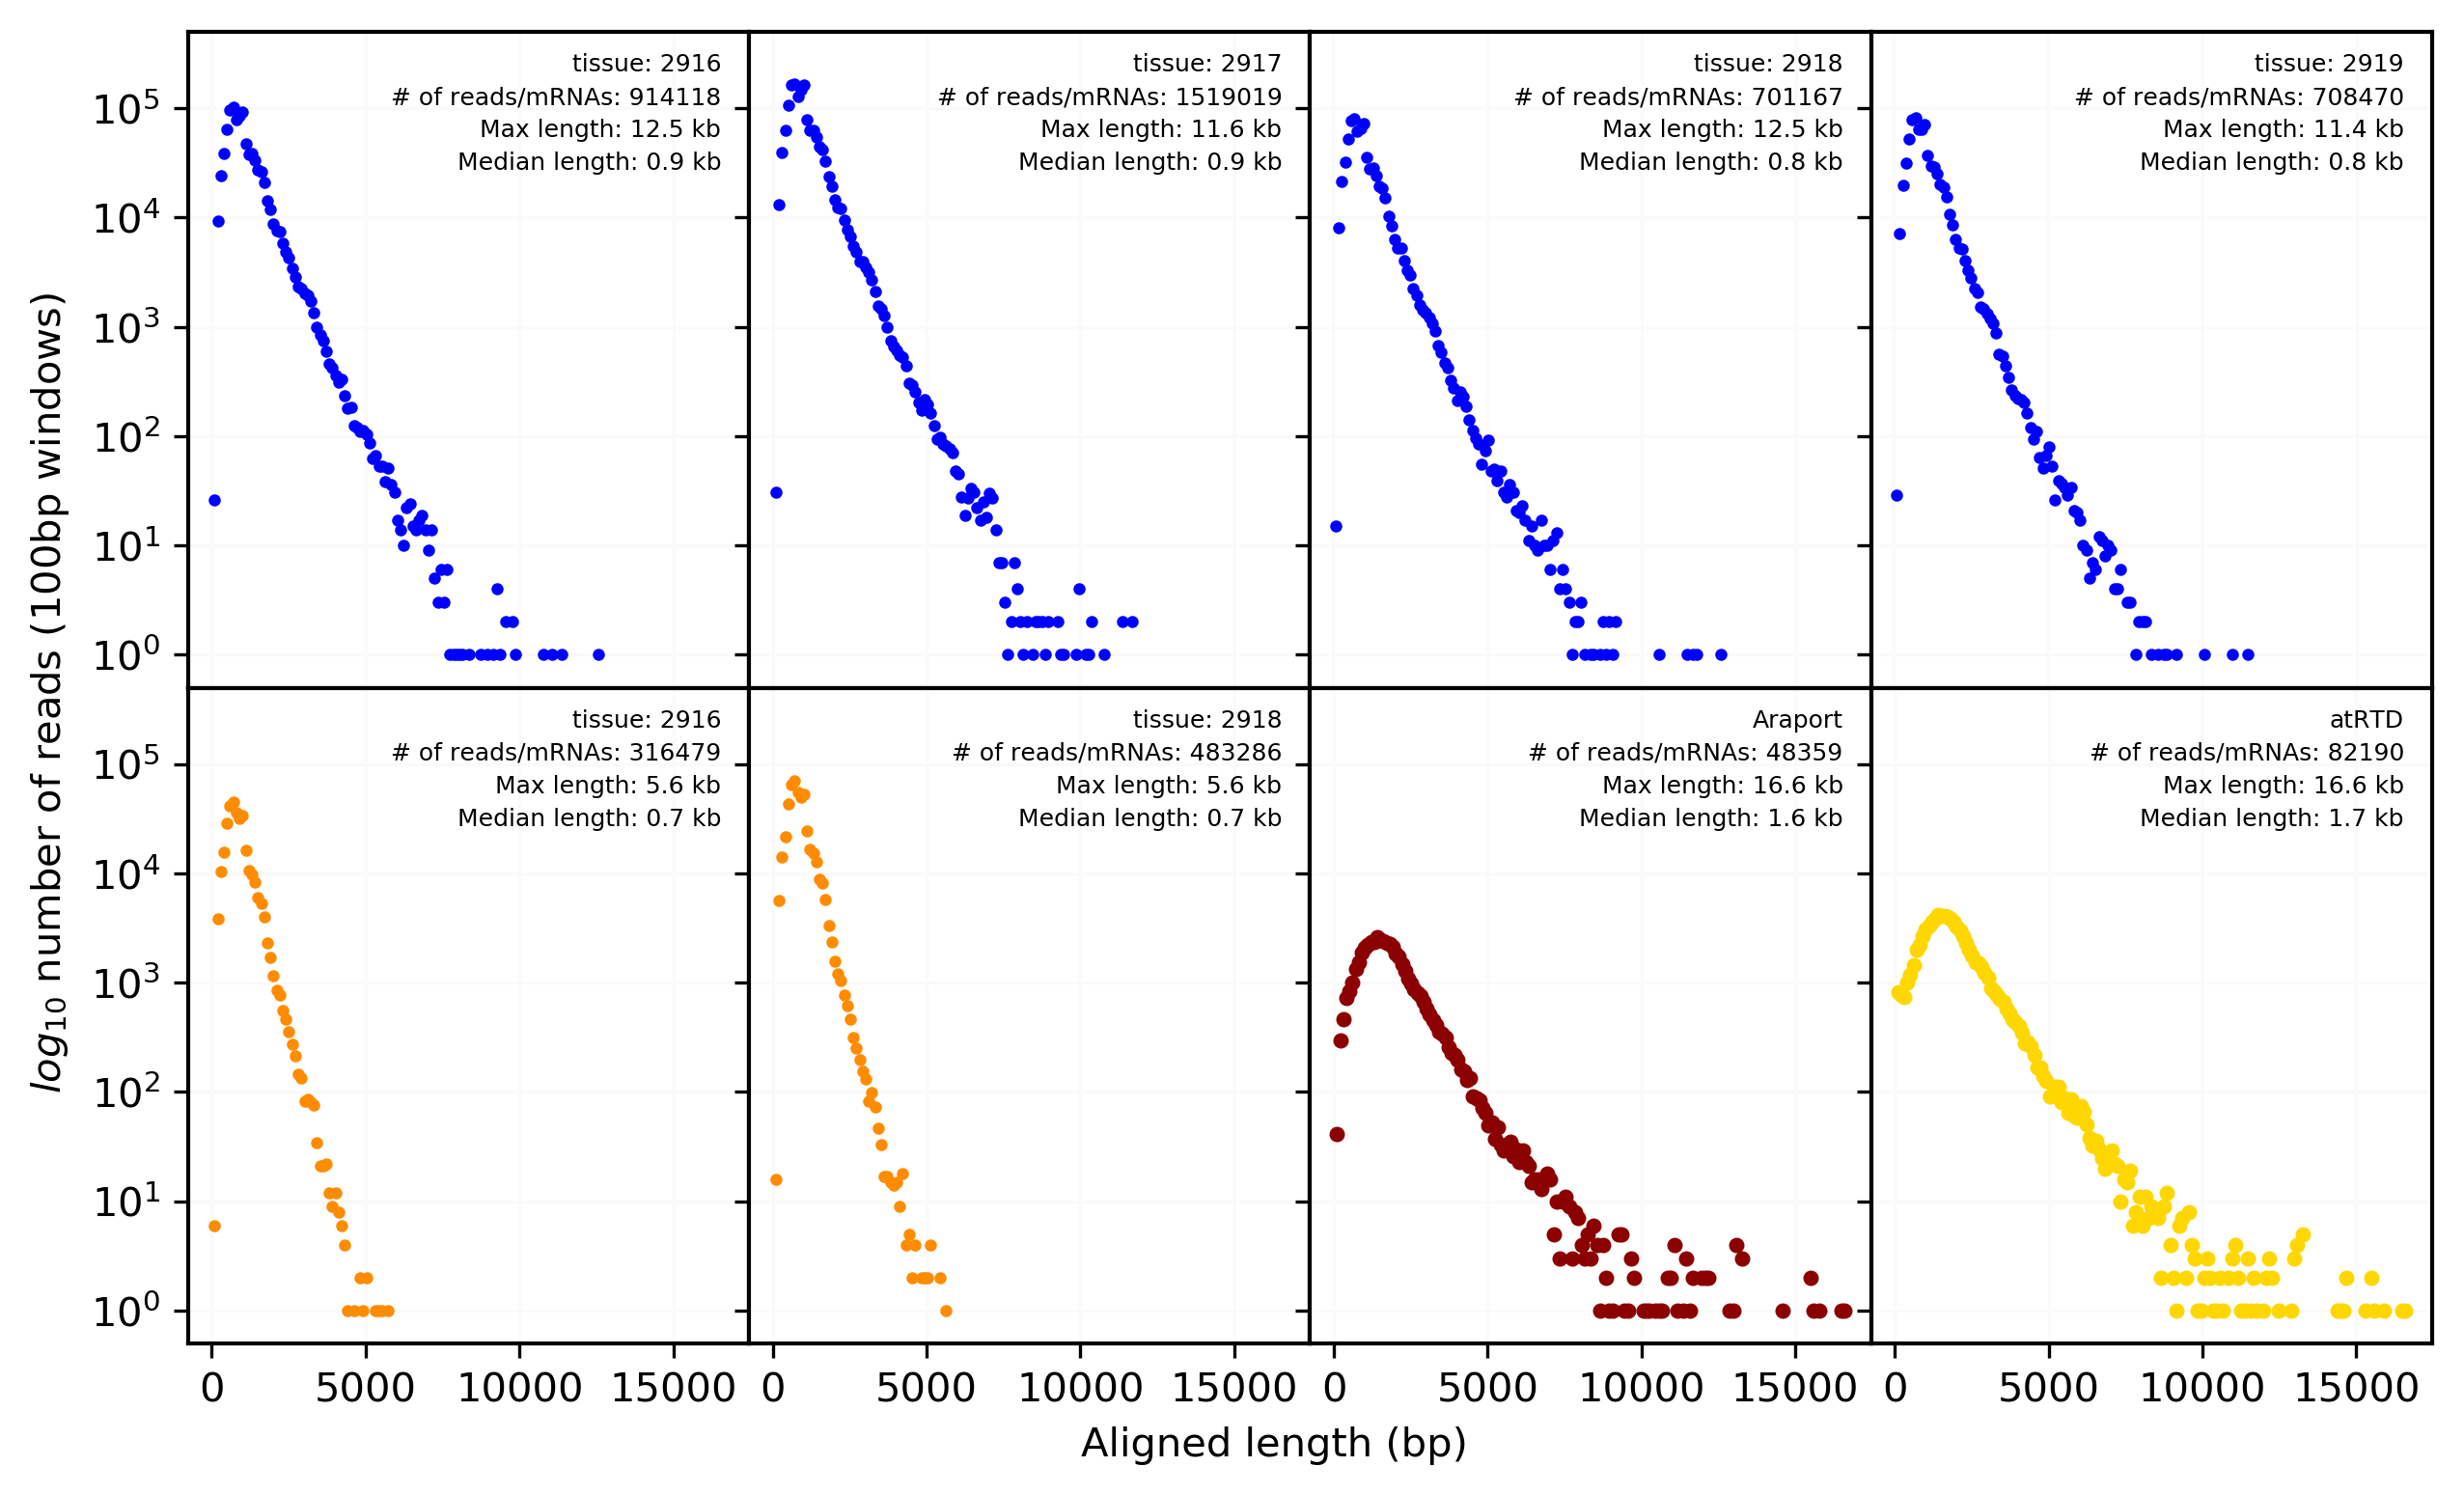

In [33]:
fig1 = plt.figure(figsize=(10,6), dpi=300)
subplot_index=1
bins=numpy.linspace(1,16600,16600/100)
axes=[]
showxlabels=False
for dataset in read_lengths.keys():
    if subplot_index == 1:
        sharey=None
        sharex=None
    elif subplot_index in [2,3,4]:
        sharey=axes[0]
        sharex=None
    elif subplot_index == 5:
        sharey=None
        sharex=axes[subplot_index-5]
    else:
        sharey=axes[4]
        sharex=axes[subplot_index-5]
    plotlabel = "tissue: {}".format(re.sub("run.+_tissue","",dataset))
    
    color='blue'
    if subplot_index == 5 or subplot_index == 6:
        color='darkorange'
        showxlabels=True
    ax = plotScatterHist(subplot_index, read_lengths[dataset][1], bins, plotlabel,
                         sharex, sharey, s=4, color=color, showxlabels=showxlabels, rows=2,
                         cols=4)
    plt.subplots_adjust(hspace=.0, wspace=.0)
    axes.append(ax)
    subplot_index+=1

# add araport plot
ax = plotScatterHist(subplot_index, araport_lens, bins, "Araport",
                     axes[subplot_index-2], axes[4], color='darkred',
                     rows=2, cols=4)
axes.append(ax)
subplot_index+=1

# add atRTD
ax = plotScatterHist(subplot_index, atRTD_lens, bins, "atRTD",
                     axes[subplot_index-2], axes[4], color='gold',
                     rows=2, cols=4)
axes.append(ax)

xlabel = fig1.text(0.5, 0.06, "Aligned length (bp)", ha='center')
ylabel = fig1.text(0.07, 0.5, r"$log_{10}$ number of reads (100bp windows)",
                   va='center', rotation='vertical')

plt.savefig("/cluster/gjb_lab/nschurch/new_cluster_workspace/ONTdrstools/Paper figures/Figure1_horiz.svg",
           format='svg', transparent=True, bbox_inches='tight', frameon=False)

In [34]:
for dataset in read_lengths.keys():
    maxlenind = numpy.where(read_lengths[dataset][1]==read_lengths[dataset][1].max())[0]
    print("{} maximum read length: {} ({})".format(dataset, read_lengths[dataset][1].max(),
                                                    read_lengths[dataset][0][maxlenind]))
    print("{} mean read length: {:.2f}".format(dataset, read_lengths[dataset][1].mean()))
    print("{} median read length: {}\n".format(dataset, numpy.median(read_lengths[dataset][1])))

run008_tissue2916 maximum read length: 12540 (['d0211713-a551-4bb6-982a-e65b4b660aa0'])
run008_tissue2916 mean read length: 992.04
run008_tissue2916 median read length: 864.0

run010_tissue2917 maximum read length: 11640 (['54f6d744-4ef7-44c7-b1d8-99ece68c768c'])
run010_tissue2917 mean read length: 991.20
run010_tissue2917 median read length: 867.0

run013_tissue2918 maximum read length: 12481 (['dde20fe6-ac51-4411-8047-5d133182678a'])
run013_tissue2918 mean read length: 962.20
run013_tissue2918 median read length: 839.0

run014_tissue2919 maximum read length: 11421 (['a0e7baf6-a037-4d08-9cc2-7a3a574d998b'])
run014_tissue2919 mean read length: 962.93
run014_tissue2919 median read length: 840.0

run011_tissue2916 maximum read length: 5645 (['9bbfac56-fe48-48ea-85b7-de7180e7140d'])
run011_tissue2916 mean read length: 814.21
run011_tissue2916 median read length: 733.0

run016_tissue2918 maximum read length: 5566 (['ffd95180-6a38-4496-8aaa-9214595aea2f'])
run016_tissue2918 mean read length

In [35]:
dataset = (araport_ids, araport_lens)
maxlenind = numpy.where(dataset[1]==dataset[1].max())[0]
print("araport maximum read length: {} ({})".format(dataset[1].max(), dataset[0][maxlenind]))
print("araport mean read length: {:.2f}".format(dataset[1].mean()))
print("araport median read length: {}".format(numpy.median(dataset[1])))
print("# araport transcripts>12.5kb: {}\n".format(sum(dataset[1]>12000)))

araport maximum read length: 16593 (['AT1G67120.1'])
araport mean read length: 1787.55
araport median read length: 1595.0
# araport transcripts>12.5kb: 18



In [36]:
dataset = (atRTD_ids, atRTD_lens)
maxlenind = numpy.where(dataset[1]==dataset[1].max())[0]
print("atRTD maximum read length: {} ({})".format(dataset[1].max(), dataset[0][maxlenind]))
print("atRTD mean read length: {:.2f}".format(dataset[1].mean()))
print("atRTD median read length: {}".format(numpy.median(dataset[1])))
print("# atRTD transcripts>12.5kb: {}\n".format(sum(dataset[1]>12000)))

atRTD maximum read length: 16593 (['AT1G67120_P1'])
atRTD mean read length: 1858.14
atRTD median read length: 1663.0
# atRTD transcripts>12.5kb: 31



In [37]:
sum(araport_lens>12000)

18